Hi this is the google colab notebook. If you want to use this in your project please export it to the google account with other folders from this repo. Structure should be the same as my. Here is my sample:

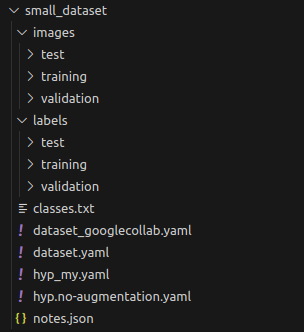

And you need "train_results" and "detection" folder.

# Import lib

In [ ]:
import glob as glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

np.random.seed(42)

# Google Colab mount drive

Mount google drive to allow you import and export data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Plot annotated images

Code below is copy with my small changes from official YOLO tutorials

In [ ]:
# Labeled names
class_names = ["bath",
"dishwasher / washing machine",
"door",
"furniture",
"refrigerator",
"sink",
"stairs",
"stove",
"table",
"wall",
"wc",
"window"]

# Set random colors for bounding boxes
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=1
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-12),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(25, 20))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                # label = label_line[0]
                # bbox_string = label_line[2:]
                # print(bbox_string)
                num, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                # print(bboxes)
                labels.append(num)
        result_image = plot_box(image, bboxes, labels)
        # print(result_image)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images. For google collab
# Change `PATH` if you want use this sample in your project
PATH = "/content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset"
plot(
    image_paths=PATH + '/images/training/*',
    label_paths=PATH + '/labels/training/*',
    num_samples=1,
)

# Set help function for dashboard

Code below is copy with my small changes from official YOLO tutorials

Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [ ]:
pip install -U tensorboard-plugin-profile


Function to Monitor TensorBoard logs.

In [ ]:
%reload_ext tensorboard

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
monitor_tensorboard()

# Clone Yolov5

This code will download YOLOv5 repository and install all requirements

In [ ]:
# Clono Yolov5 repo
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [2]:
%cd yolov5/
!pwd

/home/pan_pawel/Documents/GitHub/AECVision/yolov5
/home/pan_pawel/Documents/GitHub/AECVision/yolov5


In [ ]:
!pip install -r requirements.txt

# Train model

Here, we define wether to train the model or not and for how many epochs to train for.

If TRAIN = False, then the last trained model will be used for inference in the notebook if run end to end.

Below i write few training sets. I used them in my first training iteration. I describe each of them.

In [ ]:
TRAIN = True
# Number of epochs to train. Default in my learning process is 300
EPOCHS = 300

## Train on pretrained weights

This is basic training option. Batch-size is only 8 (optimum for my GPU is 20). Hyperparameters are default.

In [ ]:
RES_DIR = set_res_dir()
# --data - path to yaml file with data paths, change it if you want use it in your project
# --weights - use YOLO pretrained weights. Look that some YOLO models was learning on 640x640 or 1280x1280 images!
# --img - this is the size of your image
# --batch-size - size of batch
# --name - is get from RES-DIR 
# --cache - caching images increase speed of training
# --project - location where save training results
# --name - name of folder with results
if TRAIN:
    !python train.py --data /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/dataset_googlecollab.yaml --weights yolov5m.pt \
    --img 1280 --epochs {EPOCHS} --batch-size 8 --name {RES_DIR} --cache --project /content/drive/MyDrive/ColabNotebooks/AECVision/train_results --name  traine_

## Train by use set hyperparameters

This is training with hyperparameters from "Search for hyperparameters - evolve", but in my opinion something goes wrong(small hyperparameters deviation in evolve process) and evolve need to be repeat or change settings.

In [ ]:
RES_DIR = set_res_dir()
# --hyp - path to optimal hyperparameters
if TRAIN:
    !python train.py --data /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/dataset_googlecollab.yaml --weights yolov5s6.pt \
    --img 1280 --epochs {EPOCHS} --batch-size 20 --name {RES_DIR} --cache --hyp /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/hyp_my.yaml --project /content/drive/MyDrive/ColabNotebooks/AECVision/train_results --name  traine_

## Train without pretrained weights

This is the best approach to the problem because YOLO was trained to recognize different types of classes like people/cats/dogs etc. In our case objects are different. Because of that i use only YOLO model configuration.

In [ ]:
RES_DIR = set_res_dir()
# --cfg - model configuration if loaded from *.yaml file

if TRAIN:
    !python train.py --data /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/dataset_googlecollab.yaml --weights "" --cfg yolov5s6.yaml \
    --img 1280 --epochs {EPOCHS} --batch-size 20 --name {RES_DIR} --hyp /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/hyp.no-augmentation.yaml --project /content/drive/MyDrive/ColabNotebooks/AECVision/train_results --name  traine_

## Test on validation set

Normally the validation is created at the end of training but sometimes google colab kick you from your free machine. Here you can validate your model with last epoch results.

In [ ]:
# --weights - path to your result weights
if TRAIN:
    !python val.py --data /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/dataset_googlecollab.yaml --weights /content/drive/MyDrive/ColabNotebooks/AECVision/train_results/traine_best/weights/best.pt \
    --img 1280 --name {RES_DIR} --project /content/drive/MyDrive/ColabNotebooks/AECVision/train_results --name  validation_

## Search for best hyperparameters

Weights are from yolo5s because of ram use (bigger model affects ram). Batch size is default 16 maybe could be bigger. As i mentioned i think this evolve process should be improved.

In [ ]:
RES_DIR = set_res_dir()
# --evolve - number of evolving models
# --epochs - to save a lot of time i set epoch to 30 in this process
if TRAIN:
    !python train.py --data /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/dataset_googlecollab.yaml --weights yolov5s6.pt \
    --img 1280 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --cache --evolve 100

### Plot results and save

In [ ]:
# Utils is in Yolo requirements
from utils.plots import  plot_evolve

# Plot evolve results
# evolve_csv - path to your evolution results
plot_evolve(evolve_csv="/content/yolov5/runs/evolve/results_1/evolve.csv" ) # You must change path to your evolve results


In [ ]:
# Save evolve results
# Zip hyperparameters
!zip -r /content/drive/MyDrive/ColabNotebooks/AECVision/TrainRes/evolve/evolve.zip /content/yolov5/runs/evolve/

# Download
from google.colab import files
files.download("/content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/images/prediction/prediction.zip")

# Prediction

I use prediction to see results of training process and preannotate images. Preannotated images i download and import to label-studio by using label-studio converter (more here: https://github.com/heartexlabs/label-studio-converter)

## Detect images from source folder

In [ ]:
# conf - prediction confidence from 0 to 1
# source - folder with images
!python detect.py --weights /content/drive/MyDrive/ColabNotebooks/AECVision/train_results/traine_best/weights/best.pt --img 1280 --conf 0.8 --source /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/images/prediction --project /content/drive/MyDrive/ColabNotebooks/AECVision/detection --save-txt

## Download predictions

In [ ]:
# Zip images
!zip -r /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/images/preannotations/prediction.zip /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/images/preannotations
# Zip labels
!zip -r /content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/labels/prediction/prediction_txt.zip /content/yolov5/runs/detect/exp/labels/
# Download
from google.colab import files
files.download("/content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/images/prediction/prediction.zip")
files.download("/content/drive/MyDrive/ColabNotebooks/AECVision/small_dataset/labels/prediction/prediction_txt.zip")